<a href="https://colab.research.google.com/github/sandseasaw/Image-deskew-programming/blob/main/Deskewing_Image_Program_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image deskew programming

User Interface สำหรับระบบปรับภาพให้ตรงโดยใช้เทคนิค


**การใช้งาน**

มี 2 ขั้นตอน ดังนี้

1. เลือกรูปภาพของกระดาษ โดยในกระดาษจะต้องอยู่บนพื้นผิวที่ทำให้สังเกตกระดาษได้ง่าย และเห็นขอบกระดาษครบทั้ง 4 มุม และภาพไม่มืด
2. แสดงผลลัพธ์

References

1. ตัวอย่างการสร้าง Mobile Document scanner https://www.pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/
2. ตัวอย่างการสร้าง Document Scanner https://codesearchonline.com/opencv-document-scanner-python/
3. ตัวอย่างการทำ Image Rotation and Translation https://learnopencv.com/image-rotation-and-translation-using-opencv/

In [ ]:
#@title
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


Saving R1.jpg to R1 (1).jpg


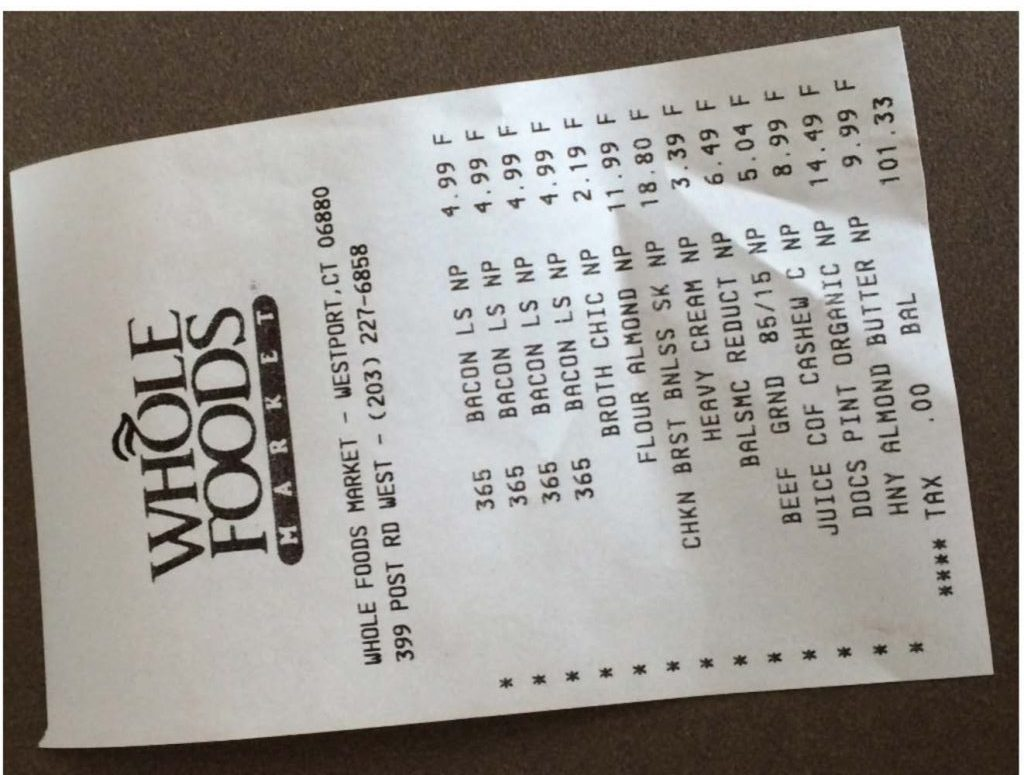

In [ ]:
#@markdown <h3> 🖼️ เลือกรูปภาพ Choose An Image</h3>
#@markdown <small>สามารถเลือกภาพตัวอย่างหรือจะอัพโหลดภาพของคุณ Pick the preset image or upload your own image</small>
import os
import cv2
import numpy as np
import pytesseract
import re
from skimage.filters import threshold_otsu, threshold_local
from google.colab.patches import cv2_imshow
from google.colab import files
from IPython.display import HTML

image = '\uD83D\uDCE4 upload your image' #@param [ '📤 upload your image']

image = ' '.join(image.split(' ')[1:])
onedrive_dataset = None

image_url = {
}

if image == 'upload your image': onedrive_dataset = ':images_upload:'
elif image in image_url:  onedrive_dataset = image_url[image]
if onedrive_dataset == None: raise Exception('Cannot select image')

preupload_datasets = None
if onedrive_dataset == ':images_upload:':
  display(HTML('<h3>Select your image</h3>'))
  dir = os.getcwd()
  uploaded = files.upload()
  preupload_datasets = [os.path.join(dir, f) for f in uploaded.keys()]
  image_fn = preupload_datasets[0]
else:
  get_ipython().system_raw('wget -O image.jpg ' + onedrive_dataset)
  image_fn = 'image.jpg'

img = cv2.imread(image_fn)
cv2_imshow(img)

In [ ]:
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgBlur = cv2.GaussianBlur(imgGray, (5,5), 1)
kernel = np.ones((2,2), np.uint8)
imgOpening = cv2.morphologyEx(imgBlur, cv2.MORPH_OPEN, kernel)
imgClosing = cv2.morphologyEx(imgOpening, cv2.MORPH_CLOSE, kernel)
imgCanny = cv2.Canny(imgClosing, 20, 240)
imgThreshold = cv2.adaptiveThreshold(imgCanny, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

In [ ]:
imgContours = img.copy()
contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]
for i in contours:
      peri = cv2.arcLength(i, True)
      approx = cv2.approxPolyDP(i, 0.02 * peri, True)
      if len(approx) == 4:
        cnts = approx
        break
cv2.drawContours(imgContours, [cnts], -1, (0,255,0), 3)

array([[[255, 255, 254],
        [255, 255, 254],
        [255, 255, 254],
        ...,
        [255, 254, 254],
        [255, 253, 255],
        [255, 253, 255]],

       [[255, 254, 253],
        [255, 254, 253],
        [255, 254, 253],
        ...,
        [255, 255, 255],
        [255, 254, 255],
        [255, 254, 255]],

       [[255, 253, 252],
        [255, 253, 252],
        [255, 253, 252],
        ...,
        [254, 254, 254],
        [255, 254, 254],
        [255, 255, 255]],

       ...,

       [[252, 255, 253],
        [244, 249, 247],
        [224, 228, 229],
        ...,
        [248, 250, 250],
        [254, 255, 253],
        [253, 254, 252]],

       [[250, 253, 251],
        [244, 249, 247],
        [225, 229, 230],
        ...,
        [248, 250, 250],
        [254, 255, 253],
        [253, 254, 252]],

       [[249, 252, 250],
        [243, 248, 246],
        [225, 229, 230],
        ...,
        [247, 249, 249],
        [254, 255, 253],
        [253, 254, 252]]

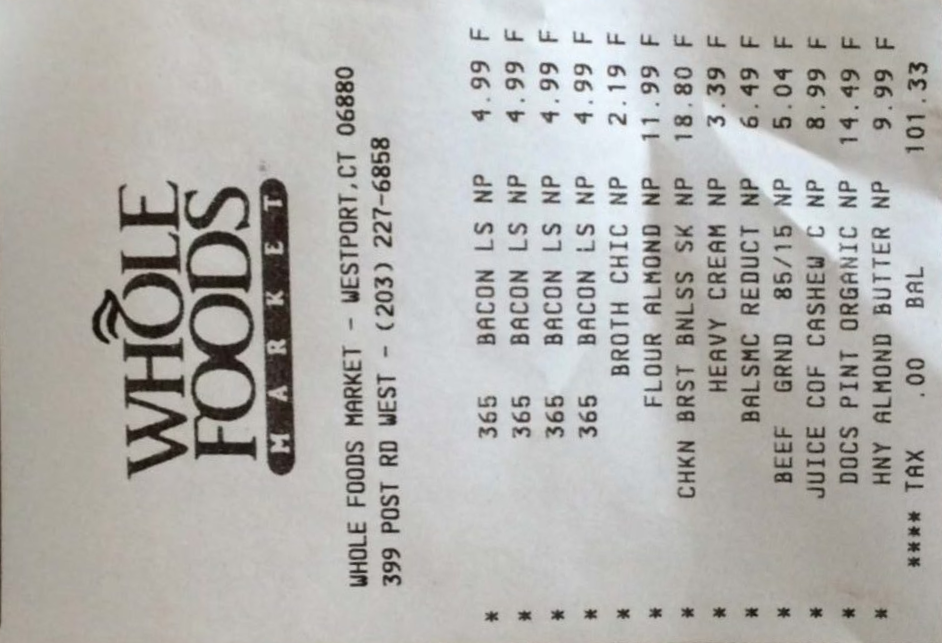

In [ ]:
def reorder(pts):
    pts = pts.reshape((4, 2))
    rect = np.zeros((4, 2), dtype=np.float32)
    add = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(add)]
    rect[2] =pts[np.argmax(add)]

    diff = np.diff(pts, axis=1)
    rect[1] =pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect


rect = reorder(cnts)
(tl, tr, br, bl) = rect

widthT = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
widthB = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))

heightL = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
heightR = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))

maxWidth = max(int(widthB), int(widthT))
maxHeight = max(int(heightR), int(heightL))

rect = np.float32(rect)
dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype = "float32")

matrix = cv2.getPerspectiveTransform(rect, dst)
imgWarp = cv2.warpPerspective(img, matrix, (maxWidth, maxHeight))
cv2_imshow(imgWarp)

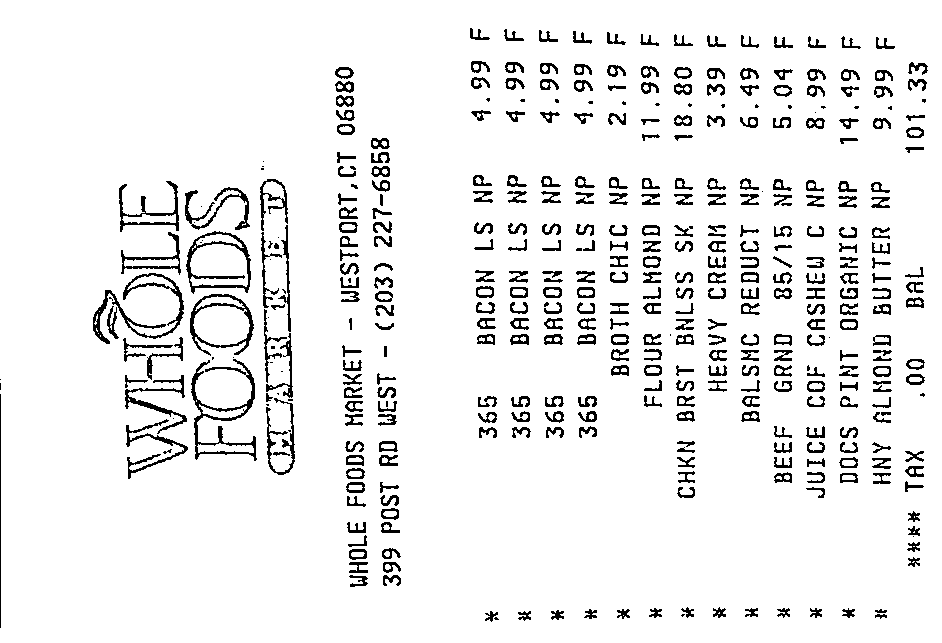

In [ ]:
imgWarp = cv2.cvtColor (imgWarp, cv2.COLOR_BGR2GRAY)
T = threshold_local(imgWarp, 11, offset = 10, method = "gaussian")
imgWarp = (imgWarp > T).astype("uint8") * 255
cv2_imshow(imgWarp)

In [ ]:
#@title 
import math
from typing import Tuple, Union
def rotate(image: np.ndarray, angle: float, background: Union[int, Tuple[int, int, int]]) -> np.ndarray:
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

In [ ]:
#@markdown <h3> แสดงผลลัพธ์จากการใช้เทคนิค OCR ตรวจจับองศาของกระดาษ </h3>
#@markdown <small> มีการหมุนรูปภาพให้ด้านของกระดาษถูกต้อง </small>
while True:
    osd_rotated_image = pytesseract.image_to_osd(imgWarp)
    print( osd_rotated_image)
    # using regex we search for the angle(in string format) of the text
    angle_rotated_image = re.search('(?<=Rotate: )\d+', osd_rotated_image).group(0)

    if (angle_rotated_image == '0'):
        imgWarp = imgWarp
        # break the loop once we get the correctly deskewed image
        break
    elif (angle_rotated_image == '90'):
        imgWarp = rotate(imgWarp,90,(255,255,255)) # rotate(image,angle,background_color)
        continue
    elif (angle_rotated_image == '180'):
        imgWarp = rotate(imgWarp,180,(255,255,255))
        continue
    elif (angle_rotated_image == '270'):
        imgWarp = rotate(imgWarp,90,(255,255,255))
        continue    
cv2_imshow(imgWarp)

In [ ]:
imgWarp = cv2.cvtColor(imgWarp, cv2.COLOR_BGR2RGB)
text = pytesseract.image_to_string(imgWarp)
print(text)